In [11]:
import torch
from torch import nn, optim
from tqdm import tqdm
from torchvision import transforms, datasets
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch.utils.data as data
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np

%matplotlib inline

In [12]:
LATENT_DIM = 64  # Latent space dimension
NUM_EMBEDDINGS = 128  # Number of vectors in codebook
COMMITMENT_COST = 0.25  # Beta in loss function
BATCH_SIZE = 128
EPOCHS = 10
LEARNING_RATE = 1e-3

In [13]:
# Define the transformation
transform = transforms.Compose([transforms.ToTensor()])

# Define DataLoaders
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST(root="./data", train=True, download=True, transform=transform),
    batch_size=64, shuffle=True
)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST(root="./data", train=False, download=True, transform=transform),
    batch_size=64, shuffle=True
)

In [14]:
def residual_stack(h, num_hiddens, num_residual_layers):
    for _ in range(num_residual_layers):
        h = nn.Sequential(
            nn.ReLU(),
            nn.Conv2d(num_hiddens, num_hiddens, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(num_hiddens, num_hiddens, kernel_size=1, stride=1, padding=0)
        )(h)
    return h

In [15]:
# Transforming from x -> z_e
class Encoder(nn.Module):
    def __init__(self, latent_dim):
        super(Encoder, self).__init__()
        self.latent_dim = latent_dim
        self.conv1 = nn.Conv2d(1, 32, kernel_size=4, stride=2, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1)
        self.conv3 = nn.Conv2d(64, latent_dim, kernel_size=3, stride=1, padding=1)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.conv3(x)  # No activation, raw latents
        residual_stack(x, self.latent_dim, 2)
        return x

In [16]:
# z_e -> z_q Codebook Dimension

class VectorQuantizer(nn.Module):
    def __init__(self, num_embeddings, embedding_dim, commitment_cost):
        super(VectorQuantizer, self).__init__()
        self.num_embeddings = num_embeddings
        self.embedding_dim = embedding_dim
        self.commitment_cost = commitment_cost
        self.embedding = nn.Embedding(num_embeddings, embedding_dim)
        self.embedding.weight.data.uniform_(-1/num_embeddings, 1/num_embeddings)
    
    def forward(self, x):
        B, C, H, W = x.shape  # Get input shape
        x_flattened = x.permute(0, 2, 3, 1).contiguous().view(-1, C)
        distances = torch.cdist(x_flattened, self.embedding.weight)
        encoding_indices = torch.argmin(distances, dim=1)
        quantized = self.embedding(encoding_indices).view(B, H, W, C).permute(0, 3, 1, 2).contiguous()
        
        loss = F.mse_loss(quantized.detach(), x) + self.commitment_cost * F.mse_loss(x.detach(), quantized)
        quantized = x + (quantized - x).detach()
        
        return quantized, loss, encoding_indices

In [20]:
# z_q -> x_hat Decoding

class Decoder(nn.Module):
    def __init__(self, latent_dim):
        super(Decoder, self).__init__()
        self.latent_dim = latent_dim
        self.conv1 = nn.ConvTranspose2d(latent_dim, 64, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1)
        self.conv3 = nn.ConvTranspose2d(32, 1, kernel_size=4, stride=2, padding=1)

    def forward(self, x):
        x = self.conv1(x)
        residual_stack(x, self.latent_dim, 2)
        x = self.conv2(x)
        x = torch.sigmoid(self.conv3(x))  # Output in [0,1]
        return  x

In [21]:
class VQVAE(nn.Module):
    def __init__(self, num_embeddings, embedding_dim, commitment_cost):
        super(VQVAE, self).__init__()
        self.encoder = Encoder(embedding_dim)
        self.quantizer = VectorQuantizer(num_embeddings, embedding_dim, commitment_cost)
        self.decoder = Decoder(embedding_dim)
    
    def forward(self, x):
        z_e = self.encoder(x)
        z_q, loss, encoding_indices = self.quantizer(z_e)
        x_hat = self.decoder(z_q)
        return x_hat, loss, encoding_indices
    
    def encode(self, x):
        return self.quantizer(self.encoder(x))[2]
    
    def decode(self, x):

        return self.decoder(x)

100%|██████████| 938/938 [00:48<00:00, 19.29it/s]


Epoch 0: Train Loss: 269.72688640654087
Test Loss: 4.80166812799871


100%|██████████| 938/938 [00:46<00:00, 20.38it/s]


Epoch 1: Train Loss: 234.70489698648453
Test Loss: 5.644162658601999


100%|██████████| 938/938 [00:48<00:00, 19.36it/s]


Epoch 2: Train Loss: 232.2381955087185
Test Loss: 5.816103123128414


100%|██████████| 938/938 [00:48<00:00, 19.22it/s]


Epoch 3: Train Loss: 231.82415072619915
Test Loss: 5.777996052056551


100%|██████████| 938/938 [00:47<00:00, 19.82it/s]


Epoch 4: Train Loss: 231.02096800506115
Test Loss: 5.462233379483223


100%|██████████| 938/938 [00:48<00:00, 19.27it/s]


Epoch 5: Train Loss: 231.0625822097063
Test Loss: 5.218217071145773


100%|██████████| 938/938 [00:48<00:00, 19.23it/s]


Epoch 6: Train Loss: 231.1532829552889
Test Loss: 5.472422294318676


100%|██████████| 938/938 [00:49<00:00, 19.10it/s]


Epoch 7: Train Loss: 230.947411775589
Test Loss: 5.497206225991249


100%|██████████| 938/938 [00:48<00:00, 19.30it/s]


Epoch 8: Train Loss: 230.2450854331255
Test Loss: 4.939288141205907


100%|██████████| 938/938 [00:49<00:00, 19.02it/s]


Epoch 9: Train Loss: 229.2881696075201
Test Loss: 5.166347183287144


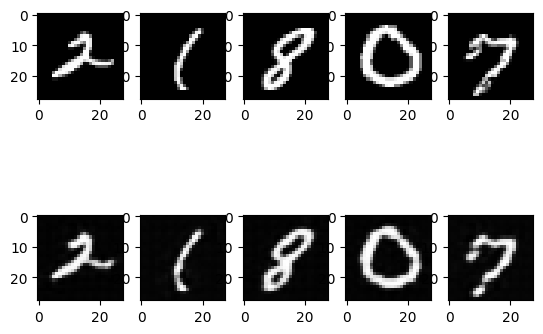

Test Loss: 5.169509029015899


In [30]:
class Trainer:
    def __init__(self, model, optimizer, train_loader, test_loader):
        self.model = model
        self.optimizer = optimizer
        self.train_loader = train_loader
        self.test_loader = test_loader
        self.train_losses = []
        self.test_losses = []

    def train(self, epochs):
        for epoch in range(epochs):
            self.model.train()
            train_loss = 0
            for batch, _ in tqdm(self.train_loader):
                self.optimizer.zero_grad()
                def add_noise(x):
                    return np.clip(x + torch.randn_like(x) * 0.1, 0, 1)
                batch = add_noise(batch)
                x_hat, loss, _ = self.model(batch)
                loss_1 = F.binary_cross_entropy(x_hat, batch)
                loss = loss.mean()
                loss += loss_1
                loss.backward()
                self.optimizer.step()
                train_loss += loss.item()
            self.train_losses.append(train_loss)
            print(f"Epoch {epoch}: Train Loss: {train_loss}")
            self.test()
    
    def visualize_reconstructions(self, n=5
    ):
        self.model.eval()
        for batch, _ in self.test_loader:
            x_hat, _, idx = self.model(batch)
            for i in range(n):
                plt.subplot(2, n, i+1)
                plt.imshow(batch[i].squeeze().detach().numpy(), cmap="gray")
                plt.subplot(2, n, i+1+n)
                plt.imshow(x_hat[i].squeeze().detach().numpy(), cmap="gray")
            plt.show()
            break

    def test(self):
        self.model.eval()
        test_loss = 0
        for batch, _ in self.test_loader:
            x_hat, loss, _ = self.model(batch)
            loss = loss.mean()
            test_loss += loss.item()
        self.test_losses.append(test_loss)
        print(f"Test Loss: {test_loss}")

model = VQVAE(NUM_EMBEDDINGS, LATENT_DIM, COMMITMENT_COST)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
trainer = Trainer(model, optimizer, train_loader, test_loader)
trainer.train(10)
trainer.visualize_reconstructions()
trainer.test()

# Recommendation

In [37]:
class Encoder(nn.Module):
    def __init__(self, num_items, embedding_dim=16, dropout_prob=0.5):
        super(Encoder, self).__init__()
        self.dense_layer_1 = nn.Linear(num_items, 256)
        self.dropout = nn.Dropout(dropout_prob)
        
        self.dense_layer_2 = nn.Linear(256, 64)  
        self.batch_norm = nn.BatchNorm1d(64)  
        
        self.dense_layer_3 = nn.Linear(64, embedding_dim)

    def forward(self, x):
        x = F.relu(self.dense_layer_1(x))
        x = self.dropout(x)
        x = F.relu(self.batch_norm(self.dense_layer_2(x)))
        x = self.dense_layer_3(x)
        return x


class Decoder(nn.Module):
    def __init__(self, num_items, embedding_dim=16, dropout_prob=0.5):
        super(Decoder, self).__init__()
        self.dense_layer_1 = nn.Linear(embedding_dim, 64)
        self.batch_norm1 = nn.BatchNorm1d(64)
        
        self.dense_layer_2 = nn.Linear(64, 256)
        self.batch_norm2 = nn.BatchNorm1d(256)
        
        self.dropout = nn.Dropout(dropout_prob)
        
        self.dense_layer_3 = nn.Linear(256, num_items)

    def forward(self, x):
        x = self.dense_layer_1(x)
        x = self.batch_norm1(x)
        x = F.relu(x)
        
        x = self.dense_layer_2(x)
        x = self.batch_norm2(x)
        x = F.relu(x)
        
        x = self.dropout(x)
        
        x = self.dense_layer_3(x)  
        x = torch.sigmoid(x)  # Assuming binary or bounded output
        return x
    
class VectorQuantizer(nn.Module):
    def __init__(self, num_embeddings, embedding_dim, commitment_cost=0.25):
        super(VectorQuantizer, self).__init__()
        self.num_embeddings = num_embeddings
        self.embedding_dim = embedding_dim
        self.commitment_cost = commitment_cost

        # Create embedding codebook
        self.embedding = nn.Embedding(num_embeddings, embedding_dim)
        self.embedding.weight.data.uniform_(-1.0 / num_embeddings, 1.0 / num_embeddings)

    def forward(self, z_e):
        # Compute distances between latent vectors and codebook vectors
        z_e_reshaped = z_e.view(-1, self.embedding_dim)  # Flatten for processing
        distances = torch.cdist(z_e_reshaped, self.embedding.weight)  # L2 distances

        # Find nearest codebook vector
        encoding_indices = torch.argmin(distances, dim=1)
        z_q = self.embedding(encoding_indices).view(z_e.shape)

        # Compute commitment loss
        loss = F.mse_loss(z_q.detach(), z_e) + self.commitment_cost * F.mse_loss(z_e.detach(), z_q)

        return z_q, encoding_indices, loss
    
class VQVAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim, num_embeddings):
        super(VQVAE, self).__init__()
        self.encoder = Encoder(input_dim, latent_dim)
        self.quantizer = VectorQuantizer(num_embeddings, latent_dim)
        self.decoder = Decoder(input_dim, latent_dim)

    def forward(self, x):
        z_e = self.encoder(x)
        z_q, encodings, vq_loss = self.quantizer(z_e)
        x_reconstructed = self.decoder(z_q)
        return x_reconstructed, vq_loss, encodings


In [35]:
class VQVAE_Rec_Sys:
    def __init__(self, dataset, num_items, embedding_dim=16, num_embeddings=128, **config):
        # Initialize the model components
        self.dataset = dataset
        self.num_items = num_items
        self.embedding_dim = embedding_dim
        self.num_embeddings = num_embeddings
        self.model = VQVAE(input_dim=num_items, hidden_dim=64, latent_dim=embedding_dim, num_embeddings=num_embeddings)
        self.optimizer = optim.Adam(self.model.parameters(), lr=0.001)
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model.to(self.device)
    
    def train(self, epochs=10, batch_size=32):
        for epoch in range(epochs):
            self.model.train()
            total_loss = 0
            for i in range(0, len(self.dataset), batch_size):
                # Get the batch from the dataset
                batch_data = self.dataset[i:i+batch_size]
                batch_data = torch.tensor(batch_data, dtype=torch.float32).to(self.device)
                
                # Zero the gradients
                self.optimizer.zero_grad()

                # Forward pass through the model
                x_reconstructed, vq_loss, _ = self.model(batch_data)

                # Compute reconstruction loss
                recon_loss = F.mse_loss(x_reconstructed, batch_data)

                # Total loss = reconstruction loss + VQ loss
                loss = recon_loss + vq_loss
                total_loss += loss.item()

                # Backward pass and optimizer step
                loss.backward()
                self.optimizer.step()

            # Print the loss for this epoch
            print(f"Epoch [{epoch+1}/{epochs}], Loss: {total_loss/len(self.dataset)}")

    def recommend_items(self, user_index, top_k=5):
        self.model.eval()
        
        # Generate the input vector for the user (e.g., user-item interaction vector)
        user_data = self.dataset[user_index]
        user_data = torch.tensor(user_data, dtype=torch.float32).unsqueeze(0).to(self.device)

        # Forward pass to get reconstructed preferences
        with torch.no_grad():
            x_reconstructed, _, encodings = self.model(user_data)

        # After reconstruction, we use the encoder's output (latent representation)
        # Here we just use the reconstructed values to recommend items
        # For simplicity, we take the reconstructed output and find the top-k items

        reconstructed_preferences = x_reconstructed.squeeze().cpu().numpy()

        # Get the top K most recommended items
        recommended_items = reconstructed_preferences.argsort()[-top_k:][::-1]
        
        return recommended_items
    
    def plot_loss(self):
        plt.plot(self.train_losses, label="Train Loss")
        plt.plot(self.val_losses, label="Validation Loss")
        plt.xlabel("Epochs")
        plt.ylabel("Loss")
        plt.legend()
        plt.show()

In [38]:
df = pd.read_csv('data/lfm_interactions.csv', sep="\t", index_col=0)
inter_matr = pd.pivot_table(df, values='count', index='user_id', columns='item_id')
inter_matr = inter_matr.fillna(0).to_numpy()
inter_matr = (inter_matr > 0).astype(int)

dataset = torch.FloatTensor(inter_matr)
rec_sys = VQVAE_Rec_Sys(dataset, num_items=500, embedding_dim=16, num_embeddings=128)
rec_sys.train(epochs=10)
#rec_sys.plot_loss()

recommended_items = rec_sys.recommend_items(user_index=0, top_k=5)

C:\Users\Justin\AppData\Local\Temp\ipykernel_18880\1854203390.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  batch_data = torch.tensor(batch_data, dtype=torch.float32).to(self.device)


RuntimeError: mat1 and mat2 shapes cannot be multiplied (32x4175 and 500x256)